# Process
In this notebook, I will analyze the dataset it and prepare it for training of Recommender systems.

## A. Import Libraries

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import read_popularity, users_and_items, user_distribution,item_distribution, calculate_popularity, calculate_group_characteristics, calculate_gini_coefficient
from plots import plot_data_distribution, plot_popularity_distribution, plot_profile_size_vs_popularity, plot_group_characteristics, plot_Lorenz
import tqdm 
from split_users import sort_user_dist, split, split_differently
import time
import pickle as pkl
from sklearn.model_selection import train_test_split
pd.set_option("display.precision", 5)

In [42]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [43]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [44]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

In [45]:
print(addition_4)

_u5_i5_t200_tfi20_tfu20_sbpf


In [46]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [47]:
#cols = ["user", "book", "rating"] # columns in the ratings dataset
df_events = pd.read_csv("data/files_with_properties/fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv", index_col=0,low_memory=False)
print('No. of user events (i.e. ratings): ' + str(len(df_events)))

No. of user events (i.e. ratings): 86356


In [48]:
df_events.head()

,User-ID,ISBN,Book-Rating,title,author,year,publisher,alt_title,alt_author,correct_author,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
1,276847,3551551677,10,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Stein der Weisen,Joanne K. Rowling,Joanne K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
2,276847,3551551685,10,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH,Harry Potter und die Kammer des Schreckens (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
3,276847,3551551693,10,Harry Potter und der Gefangene von Azkaban,J. K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Gefangene von Askaban (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
4,276847,3551551936,10,Harry Potter Und Der Feuerkelch,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Feuerkelch (Harry Potter 4),J.K. Rowling,J.K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
5,276964,0345354621,10,The Terminal Man,Michael Crichton,1988.0,Ballantine Books,The Terminal Man,Michael Crichton,Michael Crichton,...,Q172140,NaN,United States of America,NaN,deism,male,NaN,1942.0,2008.0,Michael Crichton


## D. Preprocess data
1. Convert book IDs into numbers (needed for Cornac).
2. Remove implicit ratings.
3. Remove users with too many ratings.
4. Remove users and items with only few ratings.


In [49]:
users_and_items(df_events, "User-ID", item_col) # print properties of the ratings set
user_dist, num_users = user_distribution(df_events, "User-ID", item_col, prnt = True) # create dataset for all users 
item_dist, num_items = item_distribution(df_events, "User-ID", item_col, prnt = True) # create dataset for all items

No. user events: 86356
No. items: 5504
No. users: 6354


Mean ISBNs per user: 13.6
Min ISBNs per user: 1
Max ISBNs per user: 153


Mean users per ISBN: 15.7
Min users per ISBN: 5
Max users per ISBN: 375




### Convert book IDs into numbers

In [50]:
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for ISBN in df_events.ISBN.unique():
    mapping_dict[ISBN] = i
    i+=1
# Save the mapping dictionary
with open(processed_file_location + recommendation_type + "/new_map_ISBN_to_int.pkl", "wb") as f:
    pkl.dump(mapping_dict, f)
df_events.ISBN = df_events.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [51]:
print("Final data distribution:")
user_dist, num_users = user_distribution(df_events, "User-ID", item_col, prnt=True) 
item_dist, num_items = item_distribution(df_events, "User-ID", item_col, prnt=True)
users_and_items(df_events, "User-ID", item_col) # print final properties of ratings set

Final data distribution:
Mean ISBNs per user: 13.6
Min ISBNs per user: 1
Max ISBNs per user: 153


Mean users per ISBN: 15.7
Min users per ISBN: 5
Max users per ISBN: 375


No. user events: 86356
No. items: 5504
No. users: 6354




Finally, we create an dataframe of the item characteristics that contains item popularity.

In [52]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item

In [53]:
df_item_dist.head()

,count
121,0.05902
68,0.04359
40,0.03982
413,0.03903
443,0.03730


## E. Measure diversity in data

### Gini Coefficient
Reference: https://dl.acm.org/doi/pdf/10.1145/1250910.1250939, Section 3.1

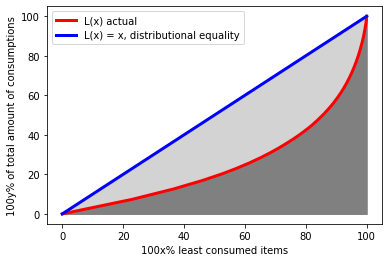

The Gini Coefficient in the data is:  0.494


In [54]:
# GINI COEFFICIENT
GC, movs, data_cdf = calculate_gini_coefficient(item_dist) # calculate gini coefficient
plot_Lorenz(movs,data_cdf, save = True, item_col=item_col, addition = addition_1) # plot lorenz curve in data
print("The Gini Coefficient in the data is: ", np.round(GC,3))

## F. Define and Calculate Popularity
An item is popular = It is among the top_fraction_items most popular items.

In [55]:
num_top = int(top_fraction_items * num_items) # choose the top_fraction_items most popular items
top_item_dist = item_dist[:num_top] #item_dist is already sorted by count, so top_item_dist is the item distribution of the "popular" items
print('No. popular items: ' + str(len(top_item_dist)))

No. popular items: 1100


In [56]:
# get pop fractions for every user
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, "User-ID", item_col) # calculate profile size, fraction of popular items, average popularity and number of popular items for all users.
#pop_count,user_hist,pop_fraq, pop_item_fraq = read_popularity(item_col)

1000
2000
3000
4000
5000
6000


## G. Plot distribution of data and popularity

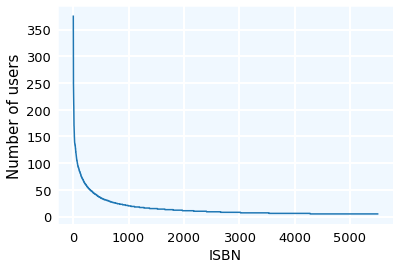

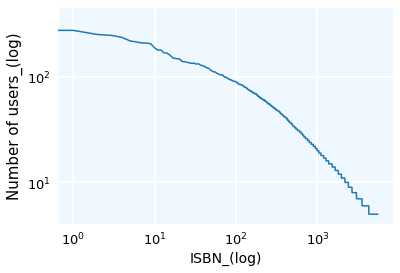

In [57]:
plot_data_distribution(item_dist, item_col, save = False, addition = addition_1) # item vs number of users
plot_data_distribution(item_dist, item_col, [False, 0],True, save = False, addition = addition_1) # item vs number of users - log scale

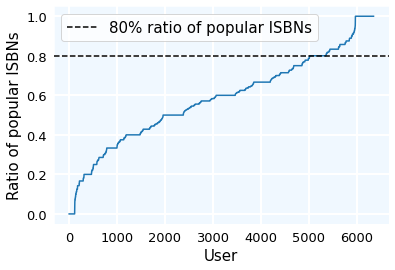

R-value: 0.929420140239003


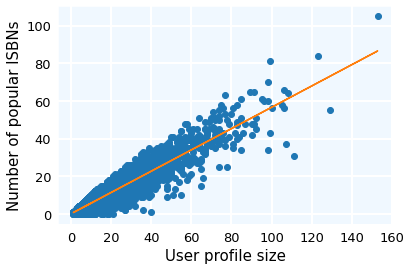

R-value: -0.030079327769241174


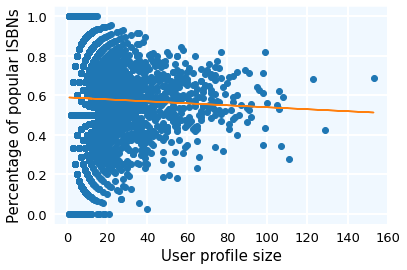

R-value: -0.04464811066022148


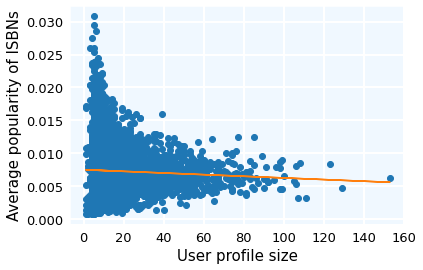

In [58]:
plot_popularity_distribution(pop_fraq, item_col, save = False, addition = addition_2) # distribution of popularity among items
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col, save = False, addition = addition_2) # number of popular vs profile size
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col, save = False, addition = addition_2) # fraction of popular vs profile size
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col, save = False, addition = addition_1) #  average popularity vs profile size

## H. Divide user groups
Divide users based on a: [top_fraction_items, 100%-2*top_fraction_items, top_fraction_items] scheme. (e.g. 20%-60%-20%).

Note 1. The users are sorted based on "split_by".

Note 2. GAP is a metric for average popularity of items in a group's users' profiles.

Note 3. MS = Mainstreaminess.

In [59]:
# Divide Users based on split_by

user_dist_sorted = sort_user_dist(user_dist, pop_count, user_hist, pop_fraq, pop_item_fraq, by = split_by)
low, med, high = split(user_dist_sorted, top_fraction_items)

low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)
print('LowMS GAP: ' + str(low_GAP))
print('MedMS GAP: ' + str(med_GAP))
print('HighMS GAP: ' + str(high_GAP))

LowMS GAP: 0.0036837892288499306
MedMS GAP: 0.007299996356588213
HighMS GAP: 0.011080921825186508


## I. Plot group characteristics
Note: Plot popularity distribution among groups only applicable when dividing by pop_fraq.

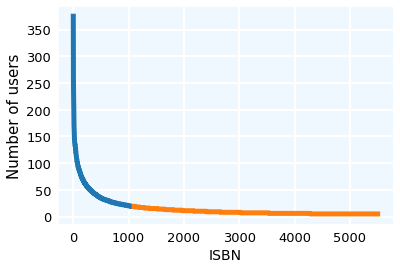

The blue items are the 'popular' ones.


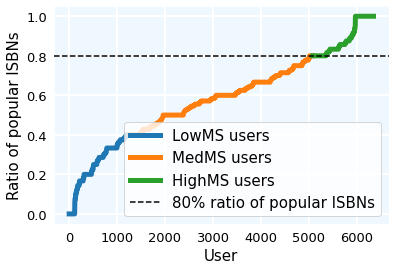

In [60]:
plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction_items], log = False, save = False, addition = addition_2)
print("The blue items are the 'popular' ones.")
plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction_items], save = False, addition = addition_3)

LowMS: 1270
MedMS: 3813
HighMS: 1271


UnboundLocalError: local variable 'ylabel' referenced before assignment

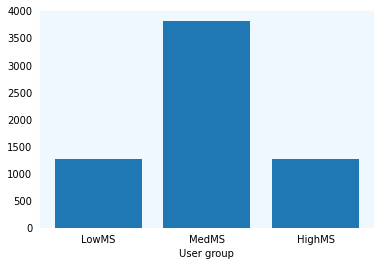

In [61]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number", item_col = item_col, save = False, addition = addition_4)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col, save = False, addition = addition_4)

## J. Save Processed Data
Now we will save all the files that are needed for training the Recommender Systems and analyzing the results.
1. The processed ratings file df_events
2. The LowMS, MedMS and HighMS users.
3. The item popularity dataframe df_item_dist.
4. The GAP of LowMS, MedMS & HighMS.

(We have already saved the "mapped" files.

In [62]:
df_events.to_csv(processed_file_location +recommendation_type +"/ratings"+addition_1+"_new.csv", index=False)

In [63]:
low.to_csv(processed_file_location + recommendation_type +"/low_users"+addition_4+"_new.csv")
med.to_csv(processed_file_location +recommendation_type + "/med_users"+addition_4+"_new.csv")
high.to_csv(processed_file_location +recommendation_type + "/high_users"+addition_4+"_new.csv")

In [64]:
df_item_dist.to_csv(processed_file_location +recommendation_type + "/item_pop_dist"+addition_1+"_new.csv")

In [65]:
GAP_list = [low_GAP, med_GAP, high_GAP]
with open(processed_file_location+recommendation_type+"/GAP_list"+addition_4+"_new.pkl", "wb") as f:
    pkl.dump(GAP_list, f)